In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import shelve
import numba as nb
import time
import random
import string



@nb.njit()
def frk4_step(y,u0,umid,u1,h,w,K,F,N):
    k1 = h * Fkuramoto_nb( y, u0,w,K,F,N)
    k2 = h * Fkuramoto_nb(y + 0.5 * k1, umid,w,K,F,N)
    k3 = h * Fkuramoto_nb( y + 0.5 * k2, umid,w,K,F,N)
    k4 = h * Fkuramoto_nb(y + k3, u1, w,K,F,N)
    y = y + (1.0 / 6.0)*(k1 + 2 * k2 + 2 * k3 + k4)
    return ((y) % (2*math.pi))



@nb.njit()
def Fkuramoto_nb(x,ut,w,K,F,N):
    y = np.empty((x.shape[0]),dtype='float64')
    R1=0
    R2=0
    for i in nb.prange(x.shape[0]):
        R2 +=np.cos(x[i])
        R1 +=np.sin(x[i])   
    for i in nb.prange(x.shape[0]):
        y[i] = w[i] - K*R2*np.sin(x[i])/N + K*R1*np.cos(x[i])/N +  F* np.sin(ut[i]-x[i])
    return y


@nb.njit()
def whipeout(N, initlen, ut0,utmid,ut1, x0, h,w,p):
    uin, K,F= p[0],p[1], p[2]
    
    
    for j in nb.prange(initlen):
        U0 = ut0[:,j]
        Umid = utmid[:,j]
        U1 = ut1[:,j]
        
        x  = frk4_step(x0,uin*U0,uin*Umid,uin*U1,h,w,K,F,N)
        x0 = x
    return x

@nb.njit()
def kura_run(N,runlen, ut0, utmid,ut1, x0, h,w,p):
    uin, K,F = p[0],p[1], p[2]
    X = np.empty((N,runlen), dtype = 'float64')
    for j in nb.prange(runlen):
        U0 = ut0[:,j]
        Umid = utmid[:,j]
        U1 = ut1[:,j]
        
        x  = frk4_step(x0,uin*U0,uin*Umid,uin*U1,h,w,K,F,N)
        x0 = x
        X[:,j] = x
    return X

@nb.njit()
def create_u(one_hot , u):
    res = np.empty( (one_hot.shape[0],1),dtype = 'float64')
    for i in nb.prange(one_hot.shape[0]):
        if one_hot[i] ==0:
            res[i,0] = u[0]
        elif one_hot[i] ==1:
            res[i,0] = u[1]
        else:
            res[i,0] = u[2]
    return res

@nb.njit()
def nb_dot( x, y): 
    res = np.zeros(1,dtype = 'float64')
    for i in nb.prange(x.shape[0]):
        res+=x[i]*y[i]
    return res

@nb.njit()
def nb_concatdot3( x, y): 
    res = np.zeros(3,dtype = 'float64')
    for i in nb.prange(x.shape[1]):
        if i==0:
            res[0]+=x[0,i]
            res[1]+=x[1,i]
            res[2]+=x[2,i]
        else:
            res[0]+=x[0,i]*y[i-1,0]
            res[1]+=x[1,i]*y[i-1,0]
            res[2]+=x[2,i]*y[i-1,0]
    return res

@nb.njit()
def nb_concatdot30( x, y): 
    res = np.zeros(3,dtype = 'float64')
    for i in nb.prange(x.shape[1]):
        if i==0:
            res[0]+=x[0,i]
            res[1]+=x[1,i]
            res[2]+=x[2,i]
        else:
            res[0]+=x[0,i]*y[i-1]
            res[1]+=x[1,i]*y[i-1]
            res[2]+=x[2,i]*y[i-1]
    return res

@nb.njit()
def NMSE(yeval,ydata):
    
    nmse = np.zeros(yeval.shape[0], dtype='float64')
    for i in nb.prange(yeval.shape[0]):
        for j in nb.prange(yeval.shape[1]):
            nmse[i] += (ydata[i,j]-yeval[i,j])**2
        nmse[i]=nmse[i]/numba_norm(ydata[i,:])**2
    return nmse



@nb.njit() 
def numba_norm(a):
    n = a.shape[0]
    norm = 0
    for i in range(n):
        norm += a[i] * a[i]
    return np.sqrt(norm)


@nb.njit()
def varRK4(t, state, dt, f, p, pvec,Up,Wout,w,N):
    tmid = t + dt*0.5
    k1 = dt*fkura_closed(t,state,p,pvec,Up,Wout,w,N) 
    k2 = dt*fkura_closed(t,state + 0.5 * k1,p,pvec,Up,Wout,w,N)
    k3 = dt*fkura_closed(t,state + 0.5 * k2,p,pvec,Up,Wout,w,N) 
    k4 = dt*fkura_closed(t + dt ,state + k3,p,pvec,Up,Wout,w,N)
    y= (state + (1.0/6.0) * (k1 + 2*k2 + 2*k3 + k4))
    return ( y % (2*math.pi))

    
@nb.njit()
def fkura_closed(t,x,p,pvec,Up,Wout,w,N):
    
    uin, K,F = p[0],p[1],p[2]
    one_hot = pvec
    
    y = np.empty(N,dtype='float64')
    R1=0
    R2=0
    
    Up0= nb_concatdot30(Wout, concat_nb0(np.sin(x), np.sin(x)**2))
    
    for i in nb.prange(N):
        R2 +=np.cos(x[i])
        R1 +=np.sin(x[i])   
    for i in nb.prange(N):
        y[i] = w[i] - K*R2*np.sin(x[i])/N + K*R1*np.cos(x[i])/N +  F* np.sin(Up0[one_hot[i]]*uin-x[i])
       
    return y

@nb.njit()
def concat_nb(x,y):
    res = np.empty( (x.shape[0]+y.shape[0],1), dtype = 'float64')
    for i in nb.prange(x.shape[0]+y.shape[0]):
        if i < x.shape[0]:
            res[i,0] = x[i,0]
        else:
            res[i,0] = y[i- x.shape[0],0 ]
    return res 

@nb.njit()
def concat_nb0(x,y):
    res = np.empty( (x.shape[0]+y.shape[0]), dtype = 'float64')
    for i in nb.prange(x.shape[0]+y.shape[0]):
        if i < x.shape[0]:
            res[i] = x[i]
        else:
            res[i] = y[i- x.shape[0] ]
    return res 

@nb.njit()
def numba_dot2(a, b):
    n = a.shape[0]
    dot = 0
    for i in range(n):
        dot += a[i] * b[i]
    return dot

@nb.njit()
def winding_row(xdiff):
    xtot =xdiff[np.where((xdiff >= -2) & (xdiff <2))].sum() - ((2*np.pi - xdiff[xdiff>2]  )).sum()  +  ((2*np.pi + xdiff[xdiff <-2])).sum()
    return xtot/(2*np.pi)

def unroll_parameter(p_dict):
    N = p_dict['N']
    K = p_dict['K']
    uin = p_dict['uin']
    h = p_dict['h']
    mu = p_dict['mu']
    sigma = p_dict['sigma']
    w = p_dict['w']
    F = p_dict['F']
    reg = p_dict['reg']
    one_hot = p_dict['one_hot']
    testlen = p_dict['test']
    trainlen = p_dict['train']
    initlen = p_dict['init']
    data_scale = p_dict['data_scale']
    return N,K,uin,h,mu,sigma,w,F,reg,one_hot,testlen,trainlen,initlen,data_scale


@nb.njit()
def solve(N,m, x0, p,pvec, Wout,u0, w,dt):
    

    X = np.zeros((N,m+1), dtype = 'float64') 

    U_pred = np.zeros((3,m+1), dtype = 'float64')
    U_pred[:,0] = u0
    Up=u0

    X[:,0] = x0

    k0=0 # indexing for first lya_dummy to compute mean and std
    t=0
    for i in range(0,m):
        t=dt+t
        X[:,i+1] = varRK4(t, X[:,i], dt, fkura_closed, p, pvec,Up,Wout,w,N)
        #print(e.shape)

        xstate = concat_nb0(np.sin(X[:,i+1]), np.sin(X[:,i+1])**2)
        Up= nb_concatdot30(Wout, xstate)


        U_pred[:,i+1]= Up  
        

 
    return  U_pred[:,1:],X[:,1:]

    
def unroll_parameter(p_dict):
    N = p_dict['N']
    K = p_dict['K']
    uin = p_dict['uin']
    h = p_dict['h']
    mu = p_dict['mu']
    sigma = p_dict['sigma']
    w = p_dict['w']
    F = p_dict['F']
    reg = p_dict['reg']
    one_hot = p_dict['one_hot']
    testlen = p_dict['test']
    trainlen = p_dict['train']
    initlen = p_dict['init']

    return N, K,uin,h,w,F,reg,one_hot,testlen,trainlen,initlen






In [2]:
with shelve.open('shelve/param.shelve','r') as shelf:
    p_dict = shelf['roes']   #'4pgqoevd'

In [3]:

with shelve.open('shelve/param.shelve','r') as shelf:
    p_dict = shelf['roes']  

with shelve.open('data/data_sets.shelve', 'r') as shelf:
    data = shelf['roes'] 
N, K,uin,h,w,F,reg,one_hot_output,testlen,trainlen,initlen = unroll_parameter(p_dict)
data_scaled = (data)/(20)+1
testlen=10_000

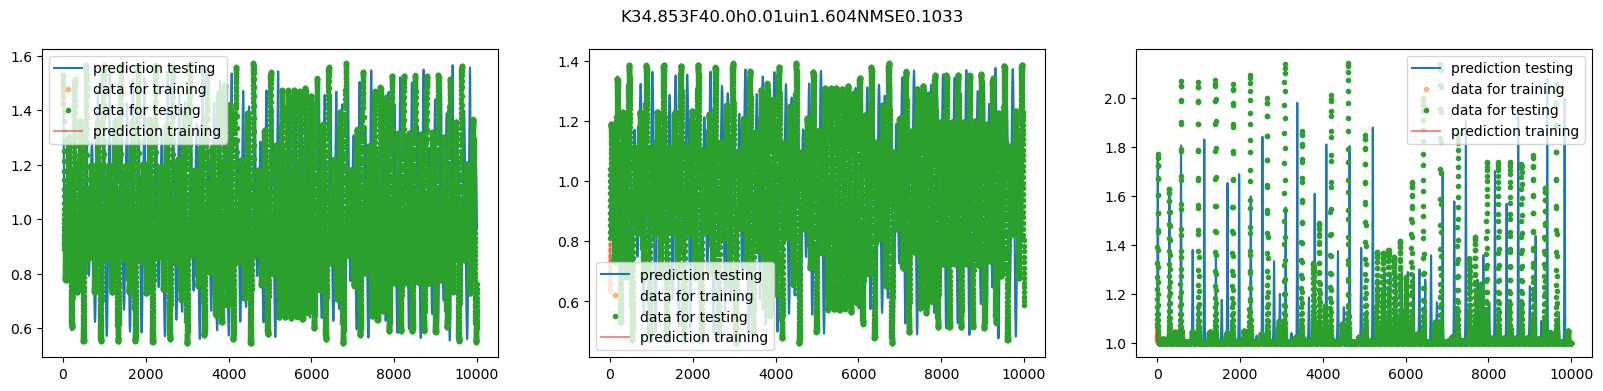

In [593]:

p = np.array([uin,K,F])
K,F= p[1],p[2]

m1 = 84
m2 = int(m1/2)

ut0 =np.eye(3)[one_hot_output] @ data_scaled[:,::m1]
utmid =np.eye(3)[one_hot_output] @ data_scaled[:,m2:][:,::m1]
ut1 =np.eye(3)[one_hot_output] @  data_scaled[:,m1:][:,::m1]

x=whipeout(N,initlen, ut0,utmid,ut1, np.linspace(0,2*math.pi,N), h, w,p)
X0= kura_run(N,trainlen, ut0[:,initlen:],utmid[:,initlen:],ut1[:,initlen:], x,h,w,p)

X =  np.concatenate((np.expand_dims(np.ones(X0.shape[1]),axis=0),np.sin(X0),np.sin(X0)**2),axis=0)


Yt = data_scaled[:,::m1][:,(initlen+1):(initlen+trainlen+1)].T


Wout = np.linalg.solve( np.dot(X,X.T) + reg*np.eye(2*N+1) , np.dot(X,Yt) ).T
pred = (Wout @ X)


nmse_train = NMSE(  np.dot(Wout,X), Yt.T).mean()

u0 = Yt.T[:,-1] #(Wout @ X[:,-1]) # #
x0= X0[:,-1] 


ydata = data_scaled[:,::m1][:, initlen+trainlen:initlen+trainlen+testlen]

U_pred,Xpred = solve(N,testlen, x0, p,one_hot_output, Wout,u0, w ,h)
nmse_test = NMSE(U_pred,ydata)

nmse_test_mean  = np.round(nmse_test.mean(),4)
fig, ax = plt.subplots(1, 3,figsize=(20,4))
fig.suptitle(f'K{K}F{F}h{h}uin{p[0]}NMSE{np.round(nmse_test_mean,4)}')
for i in range(0,3):
    ax[i].plot(U_pred[i,:testlen],label='prediction testing')
    ax[i].plot(np.arange(-10,0), Yt.T[i,-10:],'.',alpha=0.5,label='data for training')
    ax[i].plot(data_scaled[:,::m1][i, initlen+trainlen+1:initlen+trainlen+1+testlen],'.',label = 'data for testing')
    ax[i].plot(np.arange(-10,0), pred[i,-10:],alpha=0.5, label='prediction training')
    ax[i].legend()



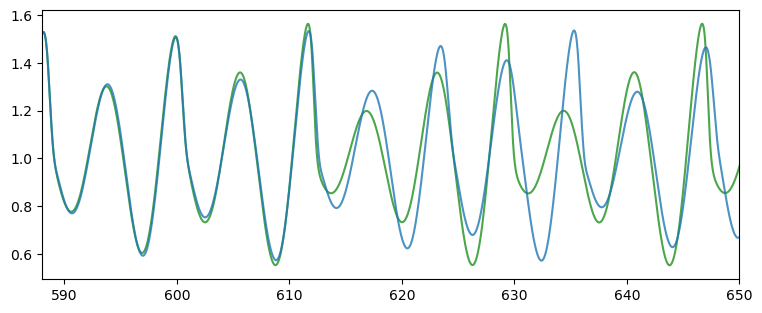

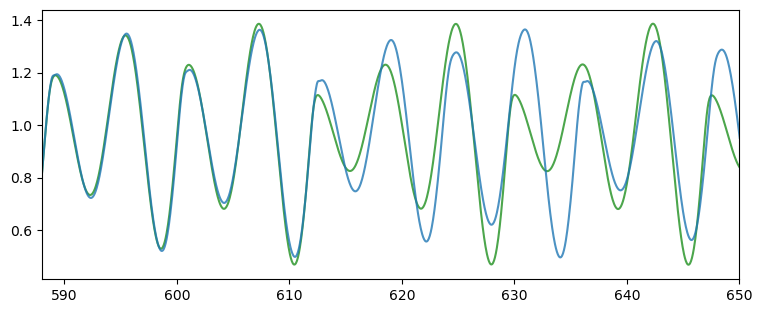

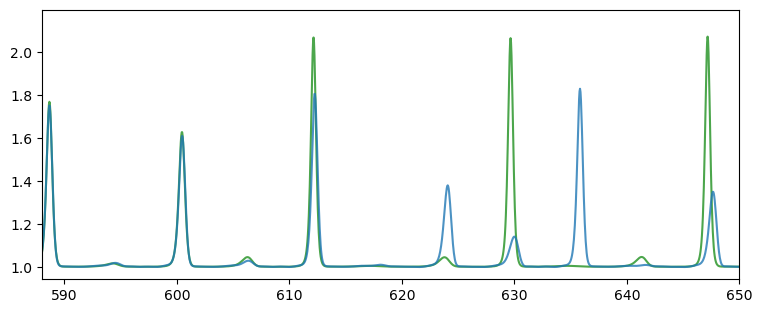

In [594]:
T=np.arange(0,testlen,1)*(84/2000) + 588
f = plt.figure() 
f.set_figwidth(9) 
f.set_figheight(3.5) 
plt.plot(T,data_scaled[:,::m1][0, initlen+trainlen+1:initlen+trainlen+1+testlen],'g',markersize=1,label = 'data',alpha=0.7)
plt.plot(T,U_pred[0,:testlen],label='prediction',alpha=0.8)
#plt.xlabel('t')
#plt.ylabel('x')
#plt.legend(loc='upper left')
plt.xlim([588,650])
plt.savefig(f'Pictures_paper/xpred.jpg',dpi=1000,bbox_inches = 'tight')
plt.show()


f = plt.figure() 
f.set_figwidth(9) 
f.set_figheight(3.5) 
plt.plot(T,data_scaled[:,::m1][1, initlen+trainlen+1:initlen+trainlen+1+testlen],'g',markersize=1,label = 'data',alpha=0.7)
plt.plot(T,U_pred[1,:testlen],label='prediction',alpha=0.8)
#plt.xlabel('t')
#plt.ylabel('y')
#plt.legend(loc='upper left')
plt.xlim([588,650])
plt.savefig(f'Pictures_paper/ypred.jpg',dpi=1000,bbox_inches = 'tight')
plt.show()

f = plt.figure() 
f.set_figwidth(9) 
f.set_figheight(3.5) 
plt.plot(T,data_scaled[:,::m1][2, initlen+trainlen+1:initlen+trainlen+1+testlen],'g',markersize=1,label = 'data',alpha=0.7)
plt.plot(T,U_pred[2,:testlen],label='prediction',alpha=0.8)
#plt.xlabel('t')
#plt.ylabel('z')
#plt.legend(loc='upper left')
plt.xlim([588,650])
plt.savefig(f'Pictures_paper/zpred.jpg',dpi=1000,bbox_inches = 'tight')
plt.show()

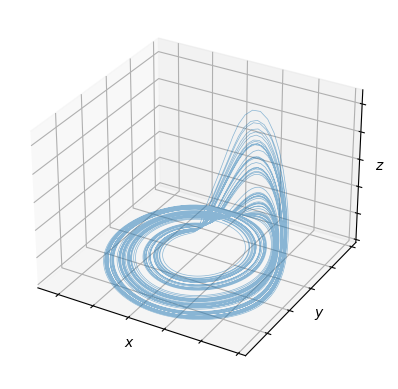

In [595]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*U_pred[:,:], lw=0.5,alpha=0.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
ax.zaxis.labelpad=-12
ax.xaxis.labelpad=-10
ax.yaxis.labelpad=-10
plt.savefig(f'Pictures_paper/U3d.jpg',dpi=300,bbox_inches = 'tight')

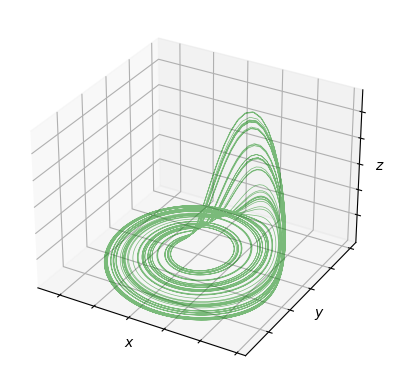

In [596]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*data_scaled[:,::m1][:, initlen+trainlen+1:initlen+trainlen+1+testlen],color='green', lw=0.5,alpha=0.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
ax.zaxis.labelpad=-12
ax.xaxis.labelpad=-10
ax.yaxis.labelpad=-10
plt.savefig(f'Pictures_paper/data3d.jpg',dpi=300,bbox_inches = 'tight')

In [4]:
Klist = []
Rlist = []
Plist = []
X0list = []
Y0list = []
Cblist = []
Slist=[]
with shelve.open(f'shelve/Kbifu9.shelve', 'r') as shelf:
    for K in shelf.keys():

        Plist.append(shelf[K][3])
        Klist.append(shelf[K][1])
        Rlist.append(shelf[K][2])
        X0list.append(shelf[K][4])
        Y0list.append(shelf[K][5])
        Cblist.append(shelf[K][7])
        Slist.append(shelf[K][8])
m=2
Karray= np.array(Klist[::m]) 
Rarray= np.array(Rlist[::m]) 
Parray= np.array(Plist[::m]) 
Cbarray=np.array(Cblist[::m])>0
Sarray = np.floor(np.abs(np.array(Slist[::m])))>0

In [5]:
Rmin  =  np.array([  min(np.sqrt(x0**2 + y0**2)[-10_000:])  for  x0,y0 in zip(X0list[::m],Y0list[::m])   ])
Rmax  =  np.array([  max(np.sqrt(x0**2 + y0**2)[-10_000:])  for  x0,y0 in zip(X0list[::m],Y0list[::m])   ])
X0_ct = np.array([  np.round(np.linalg.norm(x0[-1500:-1]-x0[-1499:],2),2)==0  for  x0 in X0list[::m]   ])
Y0_ct = np.array([  np.round(np.linalg.norm(y0[-1500:-1]-y0[-1499:],2),2)==0  for  y0 in Y0list[::m]   ])

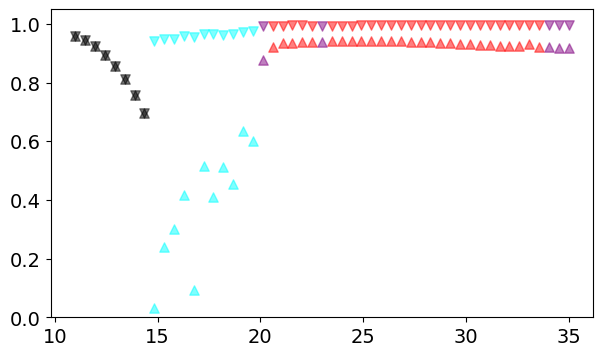

In [6]:

fig = plt.figure(figsize=(7,4))
frame1 = plt.gca()
plt.scatter(Karray[(Y0_ct + X0_ct)],Rmin[(Y0_ct + X0_ct)], color='black',marker='^', s=45, alpha=0.5)
plt.scatter(Karray[  Parray  & ((Y0_ct + X0_ct)==False) & (Cbarray == False)],\
            Rmin[  Parray  & ((Y0_ct + X0_ct)==False) & (Cbarray == False)], color='purple',marker='^', s=45, alpha=0.5)
plt.scatter(Karray[  Parray  & ((Y0_ct + X0_ct)==False) & (Cbarray==False)],\
            Rmax[  Parray  & ((Y0_ct + X0_ct)==False)& (Cbarray==False)],s=45, color='purple',marker='v', alpha=0.5)

plt.scatter(Karray[ (Parray == False)  & ((Y0_ct + X0_ct)==False) & (Cbarray == False)   ],\
            Rmin[ (Parray == False)  & ((Y0_ct + X0_ct)==False)& (Cbarray == False)    ], color='red',marker='^', s=45, alpha=0.5)
plt.scatter(Karray[(Y0_ct + X0_ct)],Rmax[(Y0_ct + X0_ct)],s=45, color='black',marker='v', alpha=0.5)

plt.scatter(Karray[Sarray],Rmin[Sarray], color='cyan',marker='^', s=45, alpha=0.5)
plt.scatter(Karray[Sarray],Rmax[Sarray], color='cyan',marker='v', s=45, alpha=0.5)
plt.scatter(Karray[ (Parray == False)  & ((Y0_ct + X0_ct)==False) & (Cbarray == False)   ],\
            Rmax[ (Parray == False)  & ((Y0_ct + X0_ct)==False)  & (Cbarray == False)  ],s=45, color='red',marker='v', alpha=0.5)
#plt.axis('off')
#frame1.axes.get_xaxis().set_visible(False)
#frame1.axes.get_yaxis().set_visible(False)
#plt.xlabel('K')
#plt.ylabel('r')
plt.ylim([0,1.05])
#plt.xlim([2,10])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(f'Pictures_paper/Kbifu.jpg',dpi=300,bbox_inches = 'tight')

14.36


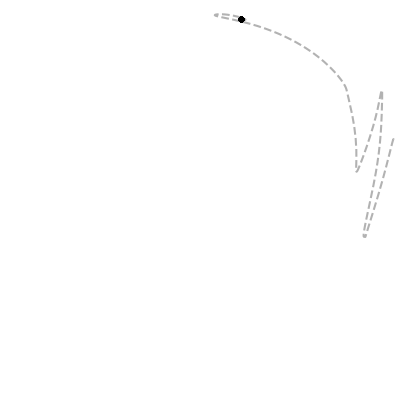

In [7]:

i=7
m1=5000
fig = plt.figure(figsize=(5,5))
plt.plot(X0list[::m][i][:m1],Y0list[::m][i][:m1],'--',color='black',alpha=0.3)
plt.plot(X0list[::m][i][m1:],Y0list[::m][i][m1:],'.',color='black',alpha=0.9)
print(Karray[i])
plt.axis('off')
plt.xlim([-0.2,1])
plt.ylim([-1,0.5])
plt.savefig(f'Pictures_paper/Kblack{Karray[i]}.jpg',dpi=200,bbox_inches = 'tight')


19.64


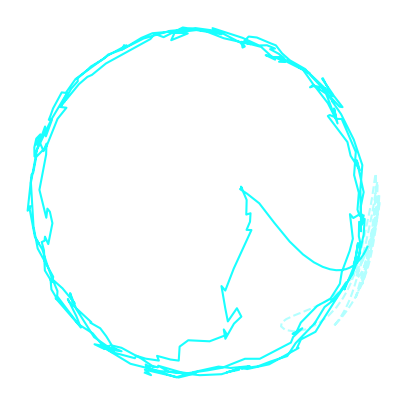

In [8]:

i=18
m1=640
m2=1000
fig = plt.figure(figsize=(5,5))
plt.plot(X0list[::m][i][:m1],Y0list[::m][i][:m1],'--',color='cyan',alpha=0.3)
plt.plot(X0list[::m][i][m1:m2],Y0list[::m][i][m1:m2],color='cyan',alpha=0.9)
print(Karray[i])
plt.axis('off')
plt.savefig(f'Pictures_paper/Kgreen{Karray[i]}.jpg',dpi=200,bbox_inches = 'tight')

35.0


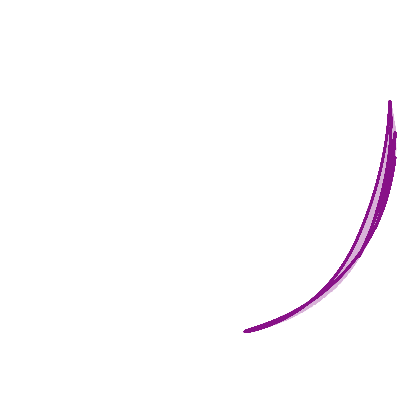

In [9]:

i=50
m1=70_000
m2=80_000
fig = plt.figure(figsize=(5,5))
plt.plot(X0list[::m][i][:m1],Y0list[::m][i][:m1],'--',color='purple',alpha=0.3,linewidth=1)
plt.plot(X0list[::m][i][m1:m2],Y0list[::m][i][m1:m2],color='purple',alpha=0.9)
print(Karray[i])
plt.xlim([-0.2,1])
plt.ylim([-1,0.5])
plt.axis('off')
plt.savefig(f'Pictures_paper/Kpurple{Karray[i]}.jpg',dpi=200,bbox_inches = 'tight')

35.0


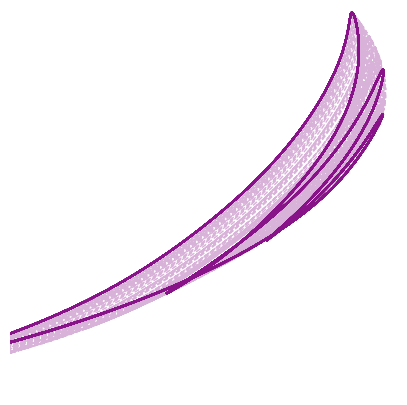

In [10]:
i=50
m1=70_000
m2=80_000
fig = plt.figure(figsize=(5,5))
plt.plot(X0list[::m][i][:m1],Y0list[::m][i][:m1],'--',color='purple',alpha=0.3,linewidth=1)
plt.plot(X0list[::m][i][m1:m2],Y0list[::m][i][m1:m2],color='purple',alpha=0.9)
print(Karray[i])
plt.xlim([0.8,1])
plt.ylim([-0.68,0.15])
plt.axis('off')
plt.savefig(f'Pictures_paper/Kzoom{Karray[i]}.jpg',dpi=200,bbox_inches = 'tight')

27.8


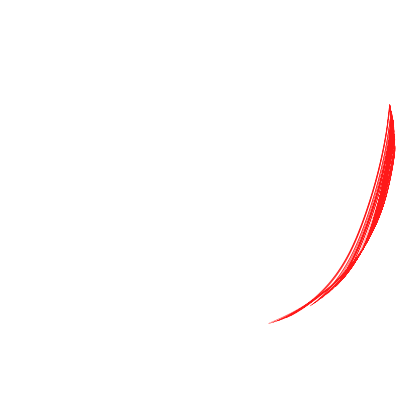

In [11]:
i=35
m1=10_000
fig = plt.figure(figsize=(5,5))
plt.plot(X0list[::m][i][:m1],Y0list[::m][i][:m1],color='red',alpha=0.9, linewidth=0.1)
print(Karray[i])
plt.xlim([-0.2,1])
plt.ylim([-1,0.5])
plt.axis('off')
plt.savefig(f'Pictures_paper/Kblue{Karray[i]}.jpg',dpi=200,bbox_inches = 'tight')

27.8


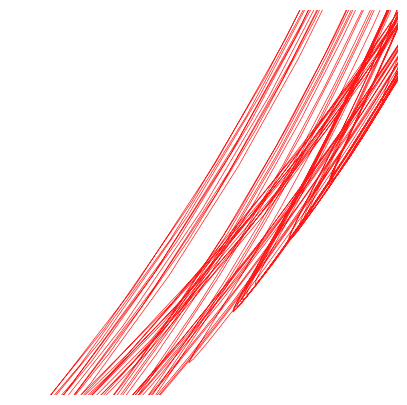

In [12]:
i=35
m1=10_000
fig = plt.figure(figsize=(5,5))
plt.plot(X0list[::m][i][:m1],Y0list[::m][i][:m1],color='red',alpha=0.9, linewidth=0.5)
print(Karray[i])
plt.xlim([0.75,0.85])
plt.ylim([-0.6,-0.5])
plt.axis('off')
plt.savefig(f'Pictures_paper/Kzoom{Karray[i]}.jpg',dpi=200,bbox_inches = 'tight')

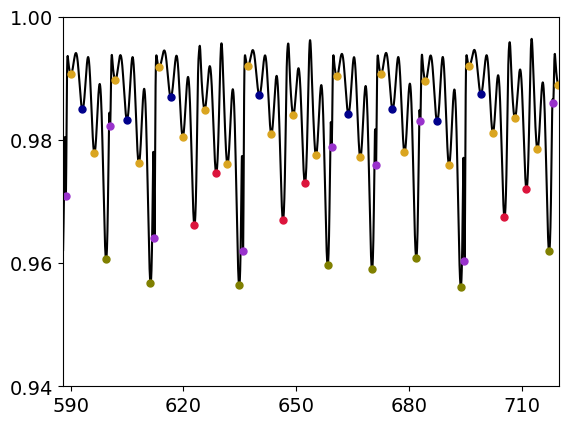

In [774]:
rtest= np.sqrt((np.cos(Xpred).sum(axis=0))**2+(np.sin(Xpred).sum(axis=0))**2)/N
rtest=rtest

drmin=[]
ilist=[]
dr=   rtest[:-1]    - rtest[1:]     
for i in range(0,len(dr)-1):
    if np.round(dr[i],10)>0 and np.round(dr[i+1],10)<0:
        drmin.append((rtest[i+1]))
        ilist.append(i)
drmin = np.array(drmin)
iarray = np.array(ilist)

ilist1 = []
ilist2 = []
ilist3 = []
ilist4 = []
ilist5 = []
for r1,r2,i in zip(drmin[:-1],drmin[1:],range(len(drmin)-1)):
    if (r2>0.988 and r1<0.99):
        ilist1.append(i)
    elif (r1<0.963) and (r2<0.99):
        ilist2.append(i)
    elif r2<(r1+0.989*(r1-0.995)):
        ilist3.append(i)
    elif r1<0.98:
        ilist4.append(i)
    else:
        ilist5.append(i)
iarray1=np.array(ilist1)
iarray2=np.array(ilist2)
iarray3=np.array(ilist3)
iarray4=np.array(ilist4)
iarray5=np.array(ilist5)


T=np.arange(0,testlen,1)*(84/2000) + 588


plt.plot(T,rtest,label='r',color='black')
#plt.plot(ilist,drmin,'.')
msize=10
plt.plot(T[iarray[iarray1]],drmin[iarray1],'.', markersize=msize,color='darkorchid',label='$I_1$')
plt.plot(T[iarray[iarray2]],drmin[iarray2],'.', markersize=msize,color='olive',label='$I_2$')
plt.plot(T[iarray[iarray3]],drmin[iarray3],'.', markersize=msize, color='goldenrod', label='$I_3$')
plt.plot(T[iarray[iarray4]],drmin[iarray4],'.', markersize=msize, color='crimson',label='$I_4$')
plt.plot(T[iarray[iarray5]],drmin[iarray5],'.', markersize=msize, color='darkblue',label='$I_5$')
plt.xlim([588,800])
#plt.ylabel('r')
#plt.xlabel('t')
plt.yticks(np.arange(0.94, 1.01, step=0.02)) 
plt.xticks(np.arange(590, 810, step=30)) 
plt.xlim([588,720])
plt.ylim([0.94,1])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(f'Pictures_paper/roes_r.jpg',dpi=600,bbox_inches = 'tight')


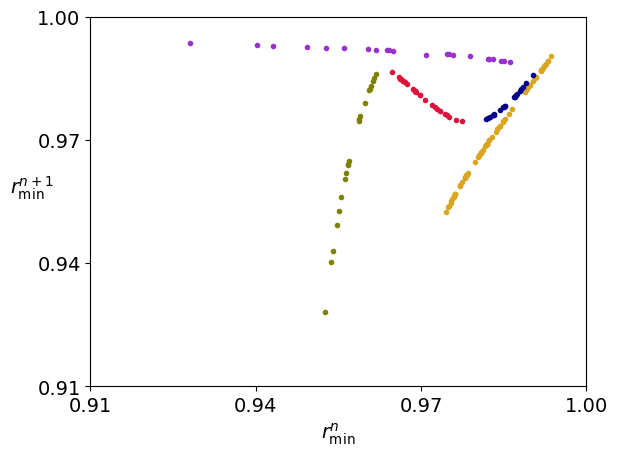

In [623]:
x0 = np.linspace(0,1,10)
#plt.plot(drmin[:-1],drmin[1:],'.')
plt.plot(drmin[:-1][iarray1],drmin[1:][iarray1],'.', color='darkorchid',label='$I_1$')
plt.plot(drmin[:-1][iarray2],drmin[1:][iarray2],'.', color='olive',label='$I_2$')
plt.plot(drmin[:-1][iarray3],drmin[1:][iarray3],'.', color='goldenrod', label='$I_3$')
plt.plot(drmin[:-1][iarray4],drmin[1:][iarray4],'.', color='crimson',label='$I_4$')
plt.plot(drmin[:-1][iarray5],drmin[1:][iarray5],'.', color='darkblue',label='$I_4$')
#plt.plot(x0,x0 + 0.989*(x0-0.995))
plt.xlabel('$r_{\min}^n$',fontsize=14)
plt.ylabel('$r_{\min}^{n+1}$',fontsize=14,rotation=0)

plt.xticks(np.arange(0.91, 1.01, step=0.03)) 
plt.yticks(np.arange(0.91, 1.01, step=0.03)) 
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(f'Pictures_paper/roes_rmin.jpg',dpi=600,bbox_inches = 'tight')

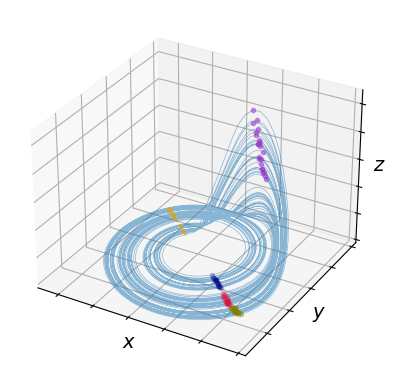

In [624]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*U_pred[:,:], lw=0.5,alpha=0.5)
ax.plot(*U_pred[:,iarray[iarray1]],'.', color='darkorchid',lw=0.1,alpha=0.5, label='$I_1$')
ax.plot(*U_pred[:,iarray[iarray2]],'.', color='olive',lw=0.1, alpha=0.3,label='$I_2$')
ax.plot(*U_pred[:,iarray[iarray3]],'.', lw=0.1,alpha=0.3, color='goldenrod', label='$I_3$',markersize=2)
ax.plot(*U_pred[:,iarray[iarray4]],'.', lw=0.1, alpha=0.2,color='crimson',label='$I_4$')
ax.plot(*U_pred[:,iarray[iarray5]],'.', lw=0.1, alpha=0.2,color='darkblue',label='$I_5$')
ax.set_xlabel('$x$',fontsize=14)
ax.set_ylabel('$y$',fontsize=14)
ax.set_zlabel('$z$',fontsize=14)
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
ax.zaxis.labelpad=-12
ax.xaxis.labelpad=-10
ax.yaxis.labelpad=-10
plt.savefig(f'Pictures_paper/roes_3d.jpg',dpi=600,bbox_inches = 'tight')

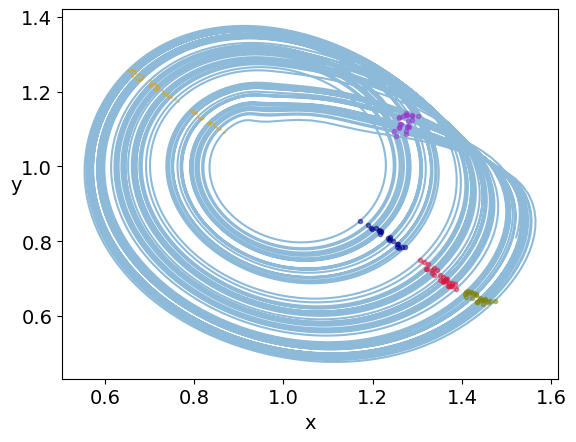

In [779]:
plt.plot(U_pred[0,:],U_pred[1,:],alpha=0.5)
plt.plot(U_pred[0,iarray[iarray1]],U_pred[1,iarray[iarray1]],'.', color='darkorchid',lw=0.5,alpha=0.5, label='$I_1$')
plt.plot(U_pred[0,iarray[iarray2]],U_pred[1,iarray[iarray2]],'.', color='olive',lw=0.5, alpha=0.5,label='$I_2$')
plt.plot(U_pred[0,iarray[iarray3]],U_pred[1,iarray[iarray3]],'.', lw=0.5,alpha=0.5, color='goldenrod', label='$I_3$',markersize=2)
plt.plot(U_pred[0,iarray[iarray4]],U_pred[1,iarray[iarray4]],'.', lw=0.5, alpha=0.5,color='crimson',label='$I_4$')
plt.plot(U_pred[0,iarray[iarray5]],U_pred[1,iarray[iarray5]],'.', lw=0.5, alpha=0.5,color='darkblue',label='$I_4$')
plt.xlabel('x',fontsize=14)
plt.ylabel('y',rotation=0,fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(f'Pictures_paper/roes_2d.jpg',dpi=600,bbox_inches = 'tight')

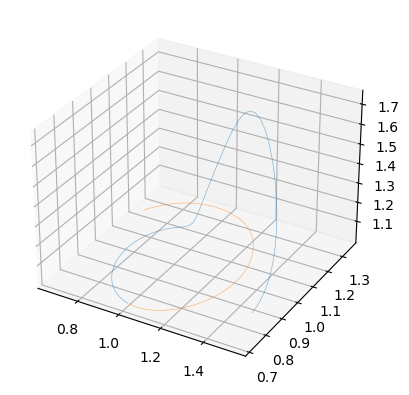

In [110]:
# checking direction flow
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*U_pred[:,:100], lw=0.5,alpha=0.5)
ax.plot(*U_pred[:,100:200], lw=0.5,alpha=0.5) 

In [7]:
Klist = []
Flist =[] 
windinglist = []
NMSE_testmean = []
with shelve.open('shelve/nmse_low.shelve', 'r') as shelf:
    for k in shelf.keys():
        if k != 'parameters':
            test_k = shelf[k][1]
            
            kdum = k.replace('K','').replace('F','').split('|')
            
            Klist.append(float(kdum[0]))
            Flist.append(float(kdum[1]))
            
            NMSE_testmean.append(test_k['NMSE_test_mean'])
            windinglist.append(test_k['winding'])

print(f'tot_parameters {len(Klist)}')

tot_parameters 400


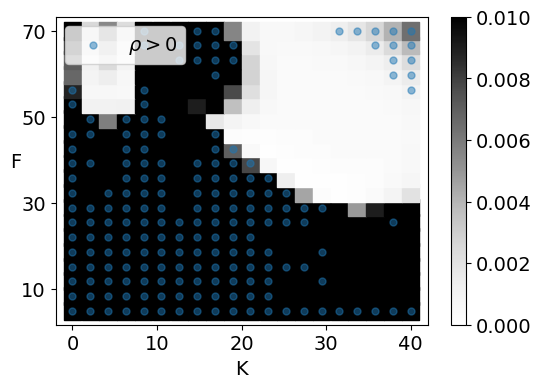

In [8]:
Karray_full= np.array(Klist)
Farray_full= np.array(Flist)
windingarray_full= np.array(windinglist).sum(axis=1)
fig = plt.figure(figsize=(6,4))
scatt = plt.scatter(Karray_full,Farray_full,c=NMSE_testmean,marker='s',s=160,cmap='Greys',vmin=0,vmax=0.01)
# plt.xlim([-0.2,30.7])
# plt.ylim([4.7,40.3])
plt.xlabel('K',fontsize=14)
plt.ylabel('F', rotation=0,fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yticks(np.arange(10, 71, step=20)) 
plt.scatter(Karray_full[windingarray_full>0],Farray_full[windingarray_full>0],marker='o',s=25, alpha=0.5,label=r"$\rho >0$")

cbar =plt.colorbar(scatt)
cbar.ax.tick_params(labelsize=14)
plt.legend(loc='upper left',fontsize=14)
plt.savefig(f'Pictures_paper/nmse_full.jpg',dpi=300,bbox_inches = 'tight')


In [9]:
Klist = []
Flist =[] 
trJlist = []
LElist = []
LElist_mean = []
LE_evo = []
windinglist = []
NMSE_testmean = []
conv_steps = []
with shelve.open('shelve/lya_low.shelve', 'r') as shelf:
    for k in shelf.keys():
        if k != 'parameters':
            test_k = shelf[k][1]
            
            kdum = k.replace('K','').replace('F','').split('|')
            
            Klist.append(float(kdum[0]))
            Flist.append(float(kdum[1]))
            
            NMSE_testmean.append(test_k['NMSE_test_mean'])
            
            LE= np.array(test_k['LE'])
            LE.sort()
            LElist.append(LE)
            trJlist.append(test_k['trJ']) 
            LEmean = np.array(test_k['LEi_sort'][-250:]).mean(axis=0)
            LElist_mean.append(LEmean)
            LE_evo.append(test_k['LEi_sort'])

            conv_steps.append(test_k['conv_steps'])
print(f'tot_parameters {len(Klist)}')
Karray= np.array(Klist)
Farray= np.array(Flist)

tot_parameters 160


In [10]:
#Note that the timesteps of the input is 84/2000 while the the time step of the reservoir is 1/100
#Hence, we need to scale the Lyapunov exponent to return to the input

l0 = np.array( [l[0] for l in LElist_mean])
l1 = np.array( [l[1] for l in LElist_mean])
l2 = np.array( [l[2] for l in LElist_mean])


t_scale = 84/20

LE1=np.array(l0)/t_scale
LE2=np.array(l1)/t_scale
LE3=np.array(l2)/t_scale


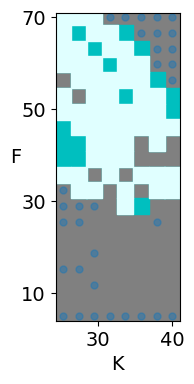

In [13]:

fig = plt.figure(figsize=(1.6,4))
msize=130
lz_like01 =  ( np.abs(LE1-0.071) <= 0.02) & (np.abs(LE2) <=0.02) & (LE3 <=-0.02)
lz_like_rest =  ( LE1 > 0.02) & (np.abs(LE2) <=0.02) & (LE3 <=-0.02)
plt.scatter(Karray, Farray, marker='s', color ='grey', s=msize)
plt.scatter(Karray[lz_like_rest],Farray[lz_like_rest],marker='s', color='c', s=msize)

plt.scatter(Karray[lz_like01],Farray[lz_like01],marker='s',s=msize, color='lightcyan')
plt.xlabel('K',fontsize=14)
plt.ylabel('F', rotation=0,fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yticks(np.arange(10, 71, step=20)) 
plt.ylim([7,71])
plt.scatter(Karray_full[windingarray_full>0],Farray_full[windingarray_full>0],marker='o',s=25, alpha=0.5,label=r"$\rho >0$")
plt.xlim([min(Karray)-1,max(Karray)+1])
plt.ylim([min(Farray)-1,max(Farray)+1])
plt.savefig(f'Pictures_paper/lya.jpg',dpi=300,bbox_inches = 'tight')